In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:03<00:00, 17.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In this notebook, we will train an XGBoost model, a Deep Neural Network (DNN), and an ensemble of these two models to identify fraudulent credit-card transactions. The data is highly imbalance, so we use the Area Under the Precision-Recall Curve (AUPRC) to evaluate the model performance. The final AUPRC we archive is around 0.90.

# Data Visualization

We are going to develop machine-learning models to identify fraudulent credit-card transaction. We first load and visualize the data in this section.

We first load the data into a DataFrame in Pandas. The DataFrame contains the time of the transactions, 28 relevant features, the amount of the transactions, and the class labels indicating whether the transactions are fraudulent.

In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3"
files = os.listdir(dataset_path)
print("Files in dataset folder:", files)


Files in dataset folder: ['creditcard.csv']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(os.path.join(dataset_path, "creditcard.csv"))
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We further load the DataFrame into a ndarray in Numpy for model trainnings. The 'Time' feature is removed because it is not useful in predicting whether future credit-card transactions are fraudulent.

In [ ]:
X = df.iloc[:, 1:-1].values
y = df['Class'].values

The data is highly imbalanced. The number of normal transactions are much larger than fraudulent transactions. This agrees with our everyday-lift experience. Below is the histogram of counts of normal and fraudulent credit-card transactions.

Since the data is highly imbalanced, we will use the Area Under the Precision-Recall Curve (AUPRC) to evaluate the model performace. The AUPRC metric do not consider the True Negative (TN) predictions which are hugh and useless in assessing the performace of models dealing with highly imbalanced data.

<ipython-input-10-ccdd35050dbd>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True).sort_index()


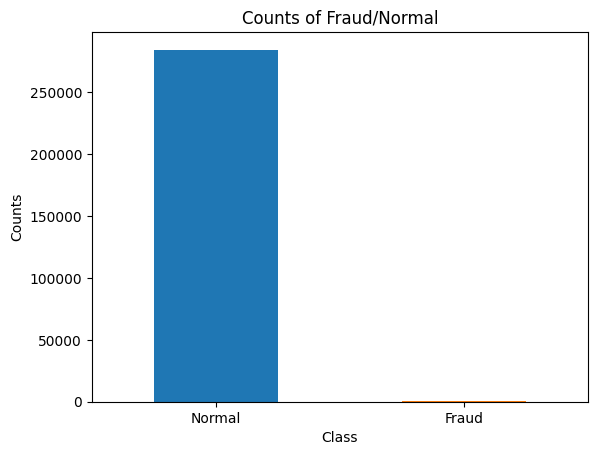

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar', color=['C0','C1'])
plt.title('Counts of Fraud/Normal')
plt.xticks(range(2), ['Normal', 'Fraud'], rotation = 0)
plt.xlabel("Class")
plt.ylabel("Counts")
plt.show()

We calculate the quotient of the counts of normal transactions devided by the counts of fraudulent transactions. This shows again how imbalance the data is. We will also use this quotient to adjust the weights in our XGBoost model.

In [ ]:
scale_pos_weight = y.shape[0] / y.sum() - 1
print('Counts of normal transactions / Counts of fraudulent transactions :', scale_pos_weight)

Counts of normal transactions / Counts of fraudulent transactions : 577.8760162601626


The correlations between the different features of the data are also explored. Most of these features are not related, so the collinearity of the independent variables is not a big problem here.

The last column and the last row also shows the correlations between independent varibles and the target variable. Although the correlations between some independent variables and the target variable are almost zero, we do not remove those independent variables in our model because they can be predictive when coupled to other independent variables. We will use a more sophiscated method to do feature selection in the next section.

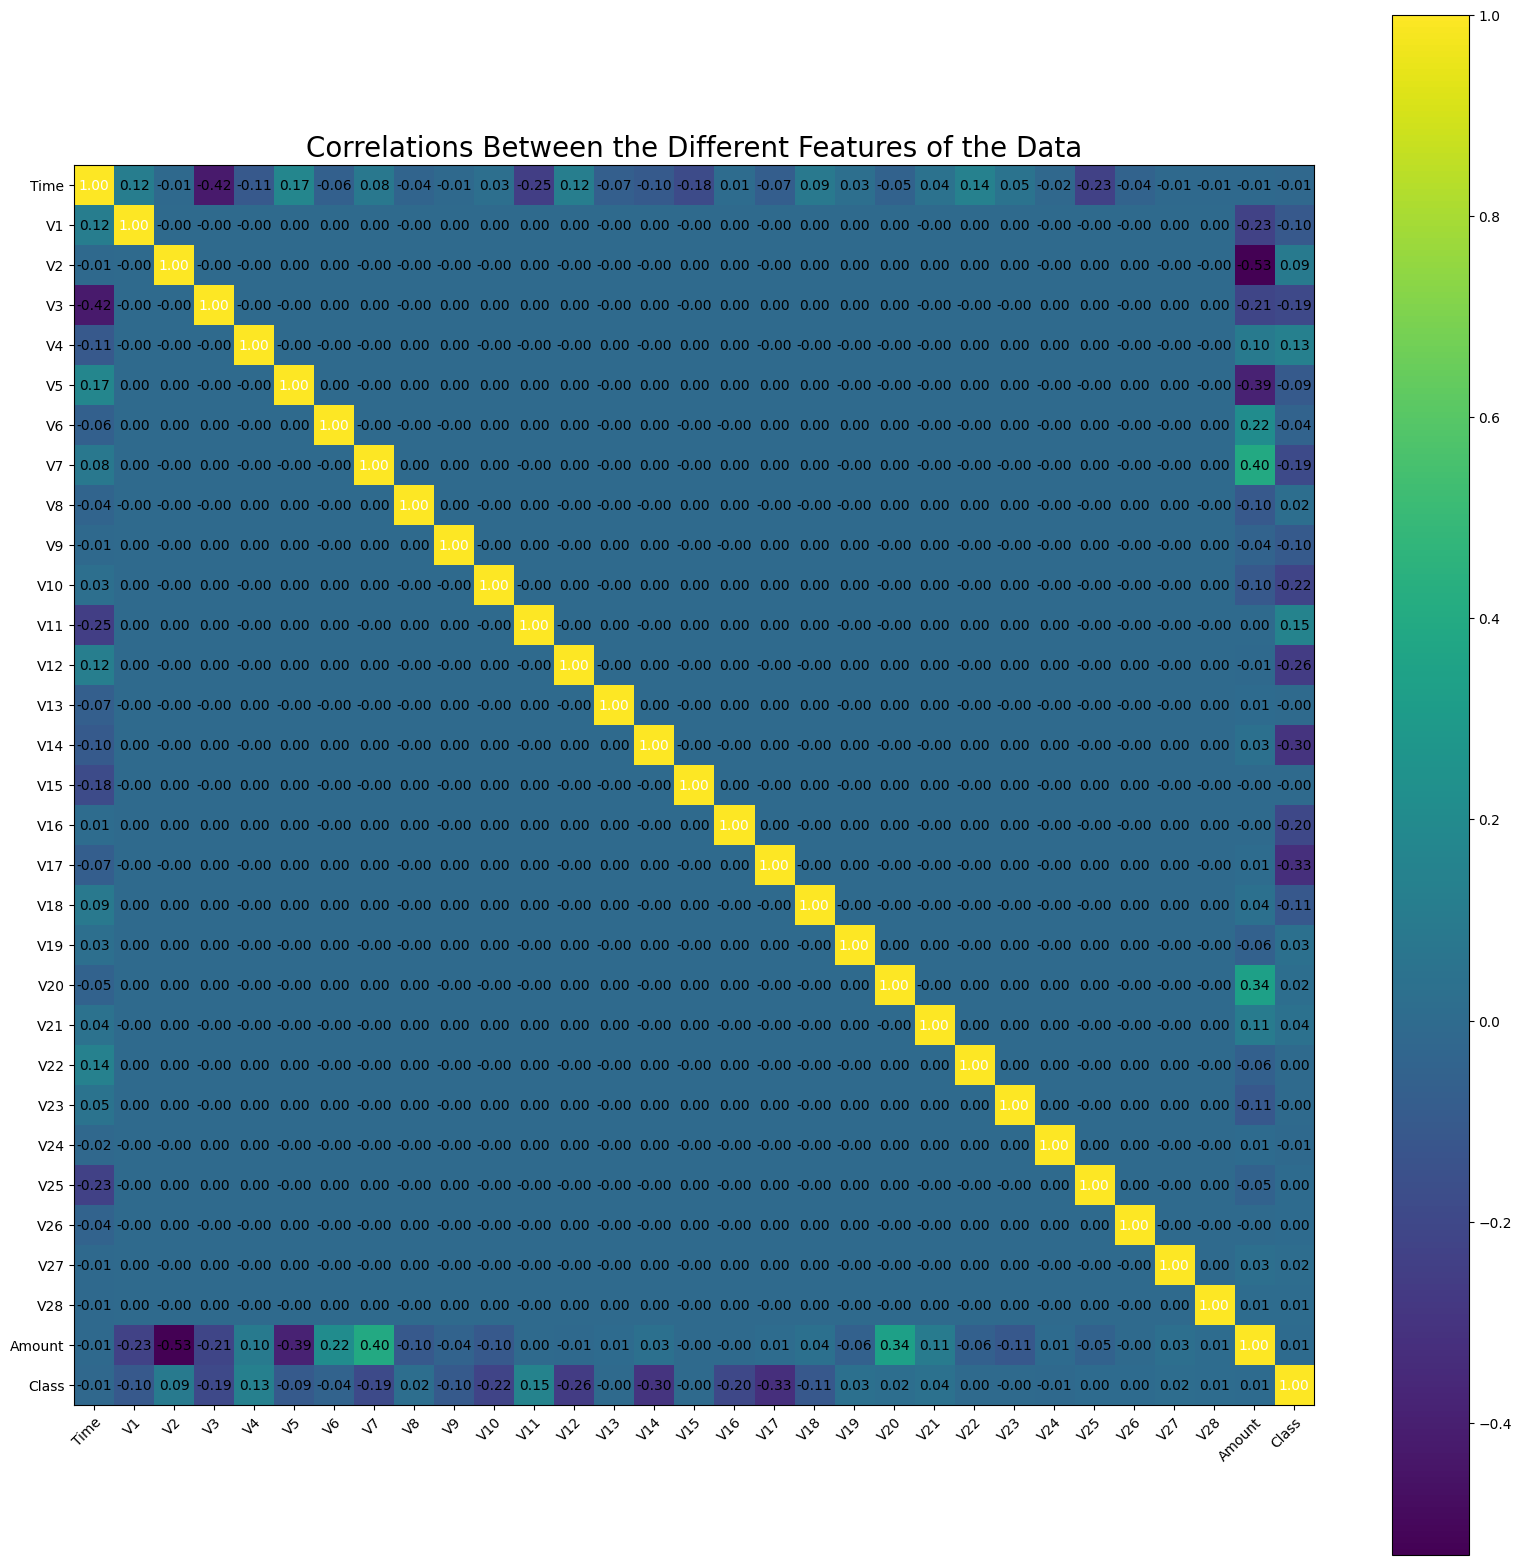

In [ ]:
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names = df.columns, column_names = df.columns, figsize = (20, 20))
plt.title('Correlations Between the Different Features of the Data', fontsize = 20)
plt.show()

We pick the two most relevant independent variables to visualize the distribution of normal and fraudulent transactions in the following figure.

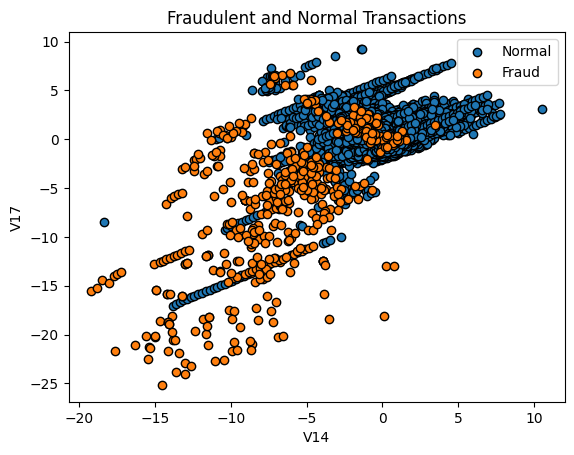

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[y == 0, 13], X[y == 0, 16], marker = 'o', linewidth=1, edgecolor='black', label = 'Normal')
plt.scatter(X[y == 1, 13], X[y == 1, 16], marker = 'o', linewidth=1, edgecolor='black', label = 'Fraud')
plt.title('Fraudulent and Normal Transactions')
plt.xlabel('V14')
plt.ylabel('V17')
plt.legend()
plt.show()

# Feature Selection Using XGBoost

We will use XGBoost to do feature selections in this section. In the end, I decide not to remove any features.

We first seperate the data into training data and testing data. I choose to use 80% as the training data and 20% as the testing data. Noticed that the division must be stratified because the data is imbalanced.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

An prilimilary XGBoost classifier is used here. The data are transformed to DMatrix to be compatible with the xgboost package.

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

param = { 'verbosity': 2,
          'objective': 'binary:logistic',
          'eval_metric': 'aucpr',
          'scale_pos_weight': scale_pos_weight,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'tree_method': 'gpu_hist',
          'eta': 0.1,
          'max_depth': 5,
          'gamma': 0,
          'min_child_weight': 1 }

bst = xgb.cv(param, dtrain, nfold = 3, num_boost_round = 1000, early_stopping_rounds = 50)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[09:32:06] INFO: /workspace/src/data/simple_dmatrix.cc:139: Generating new Ellpack page.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[09:32:07] INFO: /workspace/src/data/simple_dmatrix.cc:139: Generating new Ellpack page.
[09:32:07] INFO: /workspace/src/data/simple_dmatrix.cc:139: Generating new Ellpack page.


The Area Under the Precision-Recall Curve during the training process are showed below.

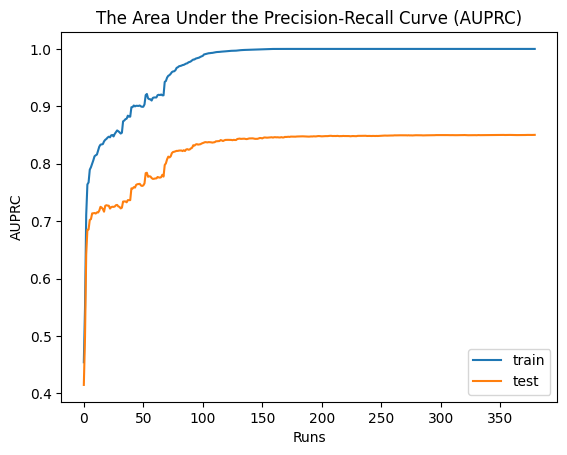

In [ ]:
import matplotlib.pyplot as plt

plt.plot(bst.iloc[:, 0], label = 'train')
plt.plot(bst.iloc[:, 2], label = 'test')
plt.legend(loc = 'lower right')
plt.xlabel('Runs')
plt.ylabel('AUPRC')
plt.title('The Area Under the Precision-Recall Curve (AUPRC)')
plt.show()

Let us look at the importance of those independent variables. The importance is calculated from how often the features are used to seperate training data in building the decision trees in the XGBoost model. None of the features looks especially irrelevant, so I decide to use all of those features in the model training.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[09:32:19] INFO: /workspace/src/data/simple_dmatrix.cc:139: Generating new Ellpack page.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


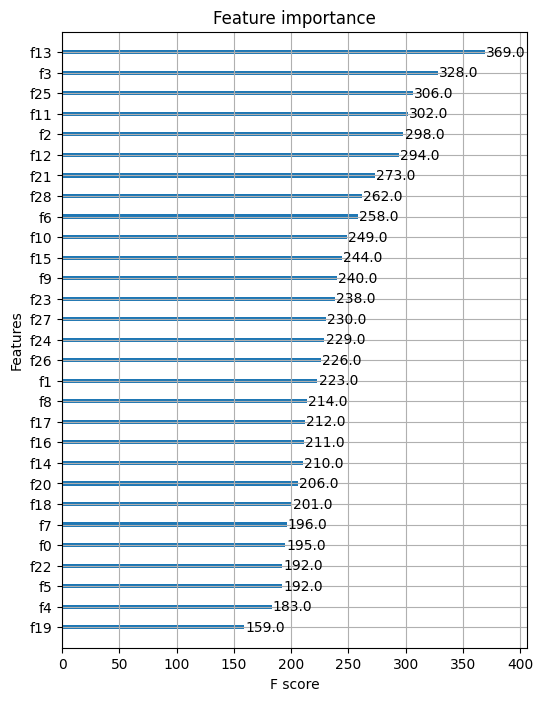

In [ ]:
best_xgb = xgb.train(param, dtrain, num_boost_round = bst.shape[0])

fig, ax = plt.subplots(figsize = (6, 8))
xgb.plot_importance(best_xgb, ax = ax)
plt.show()

Here is an example of one decision tree inside the XGBoost model.

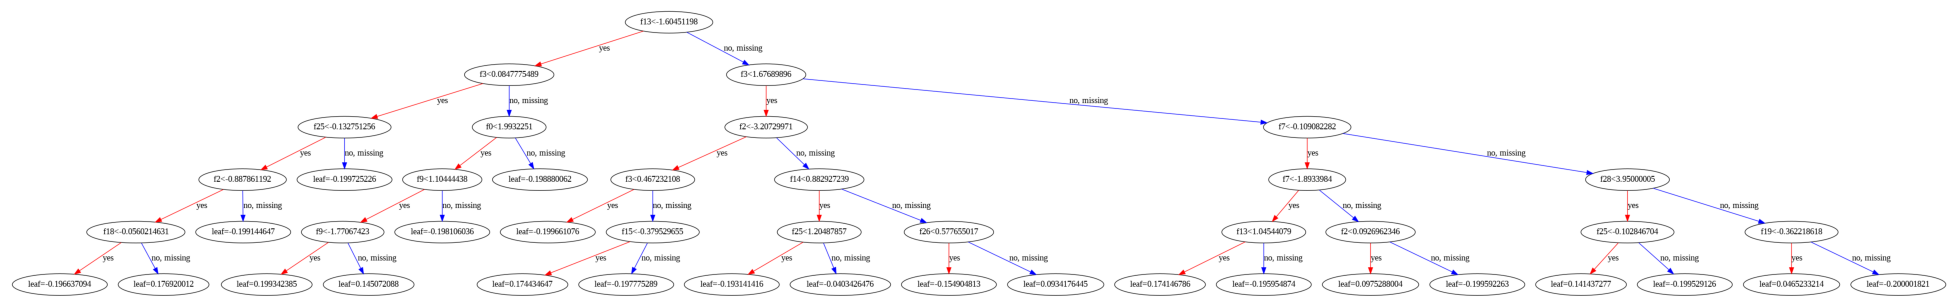

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
xgb.plot_tree(best_xgb, ax = ax)
plt.show()

# Model Training with XGBoost Classifier

In this section, we finely tune an XGBoost model to identify fraudulent credit-card transactions.

This is one example of how do I use cross-validation and grid search to tune the maximum depth of the tree and the minimum child weight. Same method can be used to tune other parameters, whose details are omitted here for brevity.

The quotient of the counts of normal transactions devided by the counts of fraudulent transactions are used in the XGBoost classifier to account for the imbalance of the data. Tree-based models are good at dealing with imbalanced data because they are forced to consider both classes in the creation of the tree.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param = {'learning_rate': 0.1,
         'verbosity': 2,
         'objective': 'binary:logistic',
         'tree_method': 'gpu_hist',
         'scale_pos_weight': scale_pos_weight,
         'n_estimators': 300}
xgb_grid = {'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3, 5],
            'gamma': [0],
            'subsample': [0.8],
            'colsample_bytree': [0.8] }
xgbc = XGBClassifier(**param)
xgbc_cv = GridSearchCV(estimator = xgbc, param_grid = xgb_grid, cv = 3, scoring = 'average_precision', n_jobs = -1, verbose = 2)
xgbc_cv.fit(X_train, y_train)
print('Best parameters: ', xgbc_cv.best_params_)
print('Best score: ', xgbc_cv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best parameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}
Best score:  0.8547828959018138


Here is the final XGBoost model I got after the tuning.

In [ ]:
best_xgbc = XGBClassifier(scale_pos_weight = scale_pos_weight,
                          objective = 'binary:logistic',
                          tree_method = 'gpu_hist',
                          max_depth = 6,
                          min_child_weight = 1,
                          gamma = 0,
                          subsample = 0.6,
                          colsample_bytree = 0.6,
                          alpha = 0,
                          learning_rate = 0.01,
                          n_estimators = 2000)

best_xgbc.fit(X_train, y_train)
y_pred = best_xgbc.predict(X_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


We evaluate the XGBoost model on the testing data. The precision-recall curve are showed below. The model looks pretty well. We can just use this as the final model.

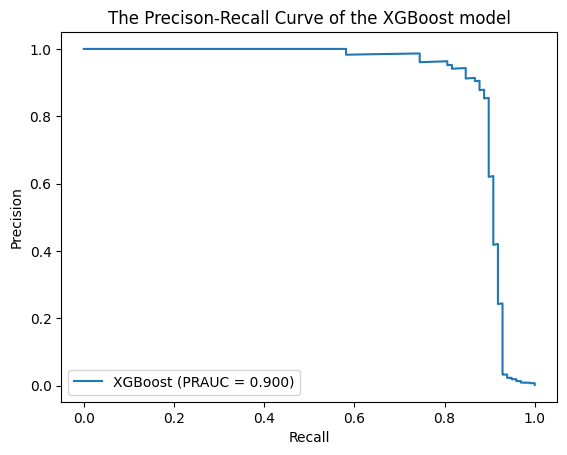

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_proba_xgb = best_xgbc.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, threshold_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)
plt.plot(recall_xgb, precision_xgb, label = 'XGBoost (PRAUC = {:.3f})'.format(auc(recall_xgb, precision_xgb)))
plt.title('The Precison-Recall Curve of the XGBoost model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower left')
plt.show()

# Oversample Instances in the Underrepresented Class

The previous XGBoost model is good enough to be used as the final model. I will show another model using deep-learning network. The deep-learning newtork cannot deal with the imbalance of the data easily, so we first oversampled the instances in the underrepresented class. Otherwise, the model will be too biased on the overrepresented class.

I divide the data into the training data, validation data, and testing data. We can also use cross-validation. I leave the details of the cross-validation to interested readers.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:-1].values
y = df['Class'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 1, stratify = y_train_val)

We define a utility function to oversample the minority class. It can be used repeatedly in the following process.

In [ ]:
from sklearn.utils import resample

def Balance(X, y, random_state = None):
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    X_minority_resample = resample(X_minority, replace = True, n_samples = X_majority.shape[0], random_state = random_state)
    X_resampled = np.vstack((X_minority_resample, X_majority))

    y_minority_resampled = np.ones((X_majority.shape[0], 1), dtype = int)
    y_majority = np.zeros((X_majority.shape[0], 1), dtype = int)
    y_resampled = np.vstack((y_minority_resampled, y_majority))

    data = np.hstack((X_resampled, y_resampled))
    np.random.shuffle(data)
    X = data[:, :-1]
    y = data[:, -1].astype(int)
    return X, y

The training data and validation data are oversampled. The testing data are not oversampled because we want to evaluate the performace of our model on the original imbalanced data.

In [ ]:
X_train_all, y_train_all = Balance(X_train_val, y_train_val, random_state = 1)
X_train_balance, y_train_balance = Balance(X_train, y_train, random_state = 1)
X_val_balance, y_val_balance = Balance(X_val, y_val, random_state = 1)

# Model Training with Deep Neural Network (DNN)

In this section, we build a Deep Neural Network (DNN) to identify fraudulent credit-card transactions.

The network contains several dense layers and several dropout layers to fight overfitting.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation = 'relu', input_shape = (29,)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,265 (4.94 KB)

 Trainable params: 1,265 (4.94 KB)

 Non-trainable params: 0 (0.00 B)

Here is a visualization of the deep neural network.

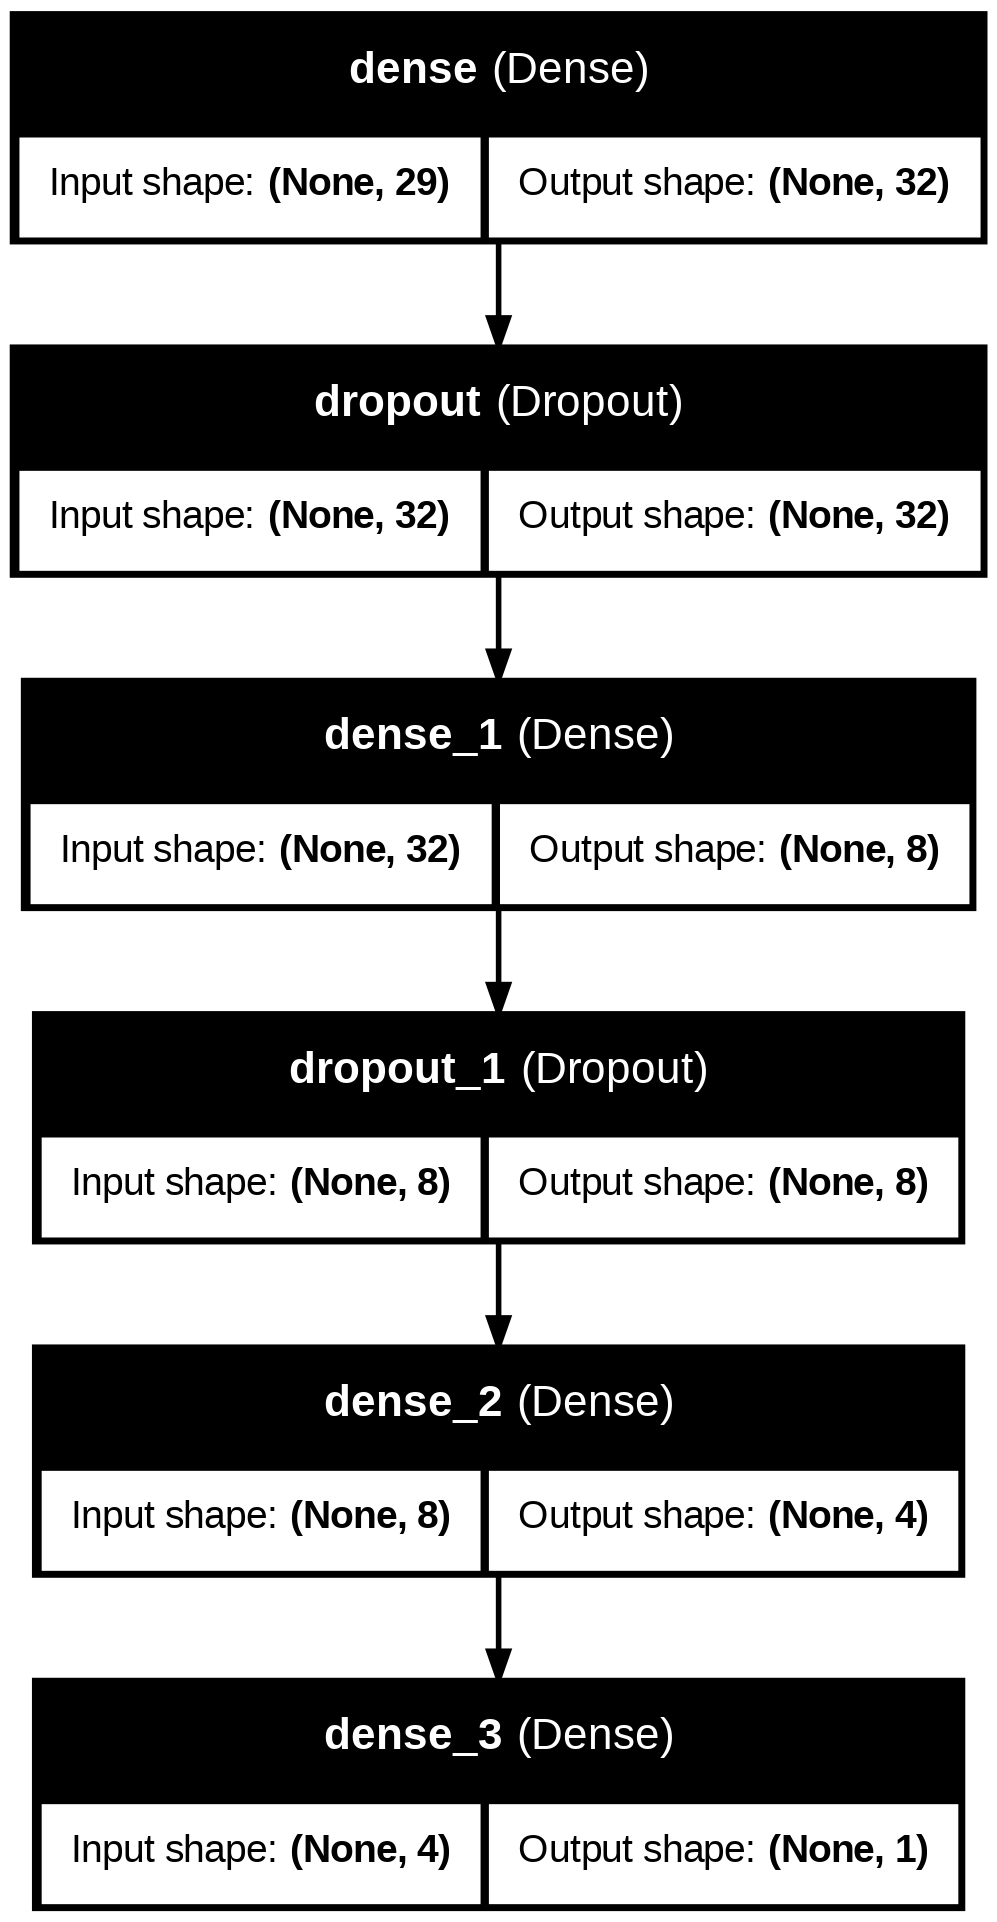

In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model)
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)


We first train the model for 20 epochs. The model is trained on the oversampled training data and evaluated on the original validation data. As before, the AUPRC are chosen as the metric of the performance.

In [ ]:
from keras import optimizers
from keras import metrics

model.compile(optimizer = optimizers.RMSprop(), loss = 'binary_crossentropy', metrics = [metrics.AUC(curve = 'PR')])
history = model.fit(X_train_balance, y_train_balance, epochs = 20, batch_size = 512, validation_data = (X_val, y_val))

Epoch 1/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - auc: 0.8073 - loss: 1.5386 - val_auc: 0.6496 - val_loss: 0.1391
Epoch 2/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.9824 - loss: 0.1702 - val_auc: 0.6660 - val_loss: 0.0755
Epoch 3/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9941 - loss: 0.0997 - val_auc: 0.6607 - val_loss: 0.0674
Epoch 4/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9967 - loss: 0.0686 - val_auc: 0.6552 - val_loss: 0.0756
Epoch 5/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9977 - loss: 0.0531 - val_auc: 0.6939 - val_loss: 0.0385
Epoch 6/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9982 - loss: 0.0433 - val_auc: 0.6712 - val_loss: 0.0239
Epoch 7/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.9985 - loss: 0.0366 - val_auc: 0.6590 - val_loss: 0.0217
Epoch 8/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9987 - loss: 0.0341 - val_auc: 0.6593 - val_loss: 0.0175
Epoch 9/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - 

The AUPRC of the training and validation data are showed below.

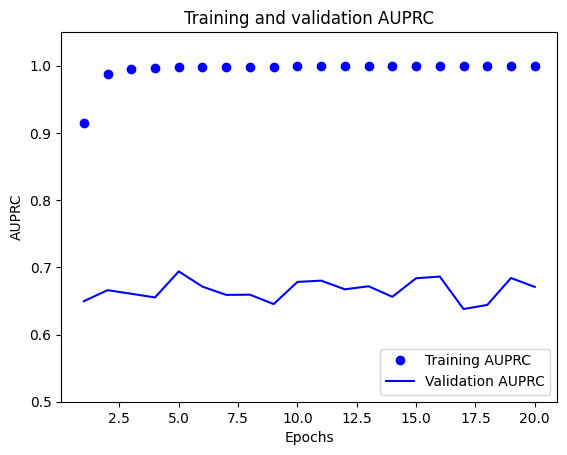

In [ ]:
train_auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(train_auc) + 1)

plt.plot(epochs, train_auc, 'bo', label = 'Training AUPRC')
plt.plot(epochs, val_auc, 'b', label = 'Validation AUPRC')
plt.title('Training and validation AUPRC')
plt.xlabel('Epochs')
plt.ylabel('AUPRC')
plt.ylim([0.5, 1.05])
plt.legend(loc = 'lower right')
plt.show()

It looks like that the model overfit quickly, so I chose to fit the model for five epoches. The final model is trained on the union of training data and validation data and is evaluated on the training data.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics

model = models.Sequential()
model.add(layers.Dense(32, activation = 'relu', input_shape = (29,)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = optimizers.RMSprop(), loss = 'binary_crossentropy', metrics = [metrics.AUC(curve = 'PR')])
history = model.fit(X_train_all, y_train_all, epochs = 5, batch_size = 512)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,265 (4.94 KB)

 Trainable params: 1,265 (4.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - auc_1: 0.8440 - loss: 0.7091
Epoch 2/5
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_1: 0.9949 - loss: 0.0909
Epoch 3/5
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_1: 0.9971 - loss: 0.0632
Epoch 4/5
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_1: 0.9980 - loss: 0.0502
Epoch 5/5
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc_1: 0.9984 - loss: 0.0432


Here is the precision-recall curve of the DNN model. It does not perform as well as the XGBoost classifier. This is probably because we only have several hundred instances in the underrepresented class. The data is not large enough to train an excellent deep-learning network.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


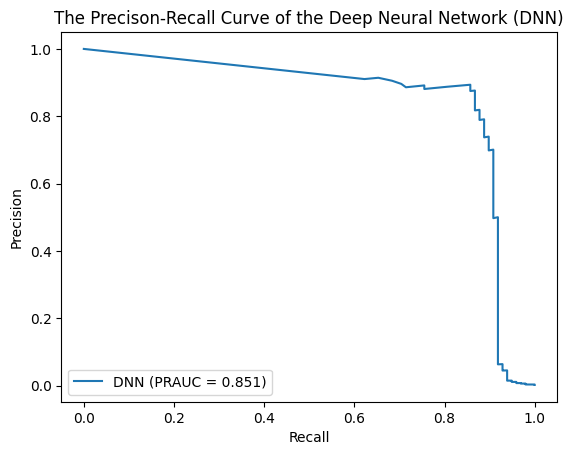

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_proba = model.predict(X_test)
precision_dnn, recall_dnn, threshold_dnn = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_dnn, precision_dnn, label = 'DNN (PRAUC = {:.3f})'.format(auc(recall_dnn, precision_dnn)))
plt.title('The Precison-Recall Curve of the Deep Neural Network (DNN)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower left')
plt.show()

# Ensemble of XGBoost and DNN

In the end we build an ensemble of the XGBoost model and the DNN. The precision-recall curve of the ensemble model are showed below.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


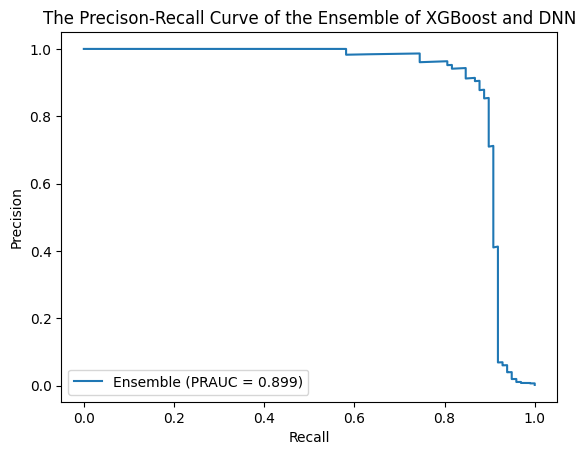

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_proba = 0.9 * best_xgbc.predict_proba(X_test)[:, 1][:, np.newaxis] + 0.1 * model.predict(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label = 'Ensemble (PRAUC = {:.3f})'.format(auc(recall, precision)))
plt.title('The Precison-Recall Curve of the Ensemble of XGBoost and DNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower left')
plt.show()

We compared the AUPRC of the XGBoost model, the DNN, and the ensemble of XGBoost and DNN. The ensemble does not increse much compared to the XGBoost model. I would vote for just using the XGBoost classifier.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


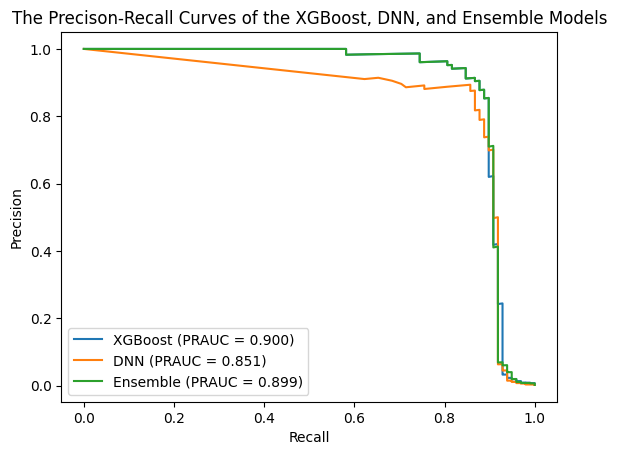

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_proba_xgb = best_xgbc.predict_proba(X_test)[:, 1][:, np.newaxis]
y_pred_proba_dnn = model.predict(X_test)
y_pred_proba = 0.9 * y_pred_proba_xgb + 0.1 * y_pred_proba_dnn
precision_xgb, recall_xgb, threshold_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)
precision_dnn, recall_dnn, threshold_dnn = precision_recall_curve(y_test, y_pred_proba_dnn)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_xgb, precision_xgb, label = 'XGBoost (PRAUC = {:.3f})'.format(auc(recall_xgb, precision_xgb)))
plt.plot(recall_dnn, precision_dnn, label = 'DNN (PRAUC = {:.3f})'.format(auc(recall_dnn, precision_dnn)))
plt.plot(recall, precision, label = 'Ensemble (PRAUC = {:.3f})'.format(auc(recall, precision)))
plt.title('The Precison-Recall Curves of the XGBoost, DNN, and Ensemble Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower left')
plt.show()